In [1]:
pip install transformers datasets torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import torch
from datasets import load_dataset, load_metric
from transformers import MBartForConditionalGeneration, MBartTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq


In [3]:
# Load mBART model and tokenizer
model_name = "facebook/mbart-large-50"
model = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer = MBartTokenizer.from_pretrained(model_name, src_lang="en_XX", tgt_lang="ta_IN")

# Load and tokenize a subset of the Opus 100 dataset for English-Tamil
train_dataset = load_dataset("opus100", "en-ta", split="train[:3%]")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/227014 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
# Function to preprocess data
def preprocess_function(examples):
    inputs = [ex['en'] for ex in examples['translation']]
    targets = [ex['ta'] for ex in examples['translation']]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# Apply the preprocessing
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Map:   0%|          | 0/6810 [00:00<?, ? examples/s]

In [5]:
# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    logging_dir='./logs',
    logging_steps=1000,
    dataloader_num_workers=0,
)

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_train_dataset,  # Use the same small dataset for evaluation
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start fine tuning
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Validation evaluation results: {eval_results}")

# Save the fine-tuned model
model.save_pretrained("./fine-tuned-mbart-en-ta")
tokenizer.save_pretrained("./fine-tuned-mbart-en-ta")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
0,No log,0.444292
2,0.428600,0.278216


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#sav

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


Validation evaluation results: {'eval_loss': 0.27821609377861023, 'eval_runtime': 135.8619, 'eval_samples_per_second': 50.124, 'eval_steps_per_second': 12.535, 'epoch': 2.9982384028185556}


('./fine-tuned-mbart-en-ta/tokenizer_config.json',
 './fine-tuned-mbart-en-ta/special_tokens_map.json',
 './fine-tuned-mbart-en-ta/sentencepiece.bpe.model',
 './fine-tuned-mbart-en-ta/added_tokens.json')

In [1]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.4 MB/s eta 0:00:00


In [7]:
# Load and tokenize the test dataset
test_dataset = load_dataset("opus100", "en-ta", split="test[:10%]")  # Load 1% for quick testing
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test evaluation results: {test_results}")

# Define a function to compute BLEU score
metric = load_metric("sacrebleu")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the predictions and references
    decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute BLEU
    bleu_score = metric.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
    return {"bleu": bleu_score["score"]}

# Generate predictions on the test set
predictions = trainer.predict(test_dataset=tokenized_test_dataset, metric_key_prefix="test")

# Compute BLEU score
metrics = compute_metrics(predictions)
print(f"BLEU score: {metrics['bleu']}")


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Test evaluation results: {'eval_loss': 0.3163084089756012, 'eval_runtime': 7.8683, 'eval_samples_per_second': 25.418, 'eval_steps_per_second': 6.355, 'epoch': 2.9982384028185556}


<ipython-input-7-aa0552c7f0fc>:10: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


The repository for sacrebleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sacrebleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
BLEU score: 6.876990988424412


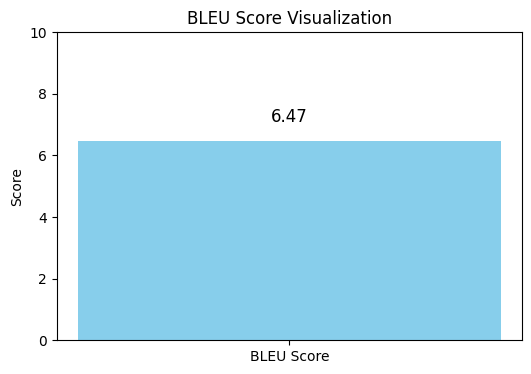

In [17]:
import matplotlib.pyplot as plt

# BLEU score
bleu_score = 6.47

# Creating a bar chart
plt.figure(figsize=(6, 4))
plt.bar(['BLEU Score'], [bleu_score], color='skyblue')

# Adding title and labels
plt.title('BLEU Score Visualization')
plt.ylabel('Score')

# Adding the actual score on top of the bar
plt.text(0, bleu_score + 0.5, f'{bleu_score:.2f}', ha='center', va='bottom', fontsize=12)

# Display the plot
plt.ylim(0, 10)  # Adjusting the y-axis limit to make the score more visible
plt.show()


In [18]:
import torch
# Translation function
def translate_text(text):
    # Check if a GPU is available and if so, move the model and inputs to the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize input text and move to device
    inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True).input_ids.to(device)

    # Generate translation
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)

    # Decode output text
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Example translation
english_text = "How are you?"
tamil_translation = translate_text(english_text)
print(f"English: {english_text}")
print(f"Tamil: {tamil_translation}")

English: How are you?
Tamil: நீங்கள் எப்படி இருக்கிறீர்கள்?


In [5]:
import sacrebleu

# Example translations and references
predictions = ["நீங்கள் எப்படி இருக்கிறீர்கள்."]
references =  [["எப்படி இருக்கிறீர்கள்."]] # List of lists, as there can be multiple references for each prediction

# Compute the TER score
ter_score = sacrebleu.corpus_ter(predictions, references)
print(f"TER score: {ter_score.score}")


TER score: 50.0


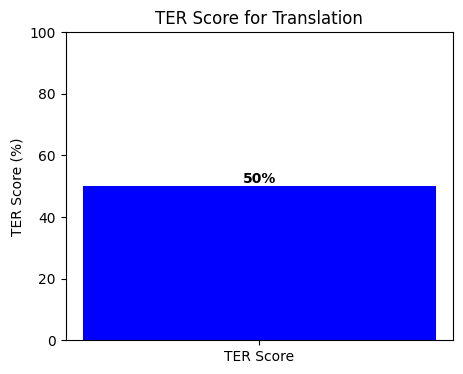

In [16]:
import matplotlib.pyplot as plt

# Your TER score
ter_score = 50

# Data for plotting
scores = [ter_score]
labels = ['TER Score']

# Create a bar chart
plt.figure(figsize=(5, 4))  # Size of the figure
plt.bar(labels, scores, color='blue')

# Add title and labels
plt.title('TER Score for Translation')
plt.ylabel('TER Score (%)')
plt.ylim(0, 100)  # Setting the limit from 0 to 100 to reflect percentage

# Show the score on top of the bar
for i, v in enumerate(scores):
    plt.text(i, v + 1, f'{v}%', ha='center', fontweight='bold')

# Display the plot
plt.show()
